In [2]:
from hydra import compose, initialize
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ergochemics.mapping import rc_to_nest
from collections import defaultdict
from scipy.stats import gmean, hmean

with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

In [14]:
rule_id = str(1009)
mc = pd.read_csv(
    Path(filepaths.interim_data) / rule_id / "mech_coverage.csv",
)
ss = pd.read_csv(
    Path(filepaths.interim_data) / rule_id / "summary_stats.csv",
)
basic = pd.read_csv(
    Path(filepaths.interim_data) / rule_id / "basic.csv",
)
Ni = int(basic["n_rxns"][0])
mc["freq_lb"] = mc["scl_lb"] / Ni
ss["freq_lb"] = ss["scl_lb"] / Ni
mc.head()

,scl_lb,mech_id,inf_id,coverage,atom_ratio,freq_lb
0,1,0,0,0.750000,2.500000,0.005814
1,1,1,0,0.666667,3.333333,0.005814
2,1,2,0,0.500000,2.500000,0.005814
3,1,3,0,0.500000,1.666667,0.005814
4,1,4,0,0.400000,2.000000,0.005814


In [15]:
ss.tail(15)

,scl_lb,n_novel_subgraphs,n_total_inferred,rxn_cov_frac,freq_lb
71,143,0,0,0.0,0.831395
72,145,0,0,0.0,0.843023
73,147,0,0,0.0,0.854651
74,149,0,0,0.0,0.866279
75,151,0,0,0.0,0.877907
76,153,0,0,0.0,0.889535
77,155,0,0,0.0,0.901163
78,157,0,0,0.0,0.912791
79,159,0,0,0.0,0.924419
80,161,0,0,0.0,0.936047


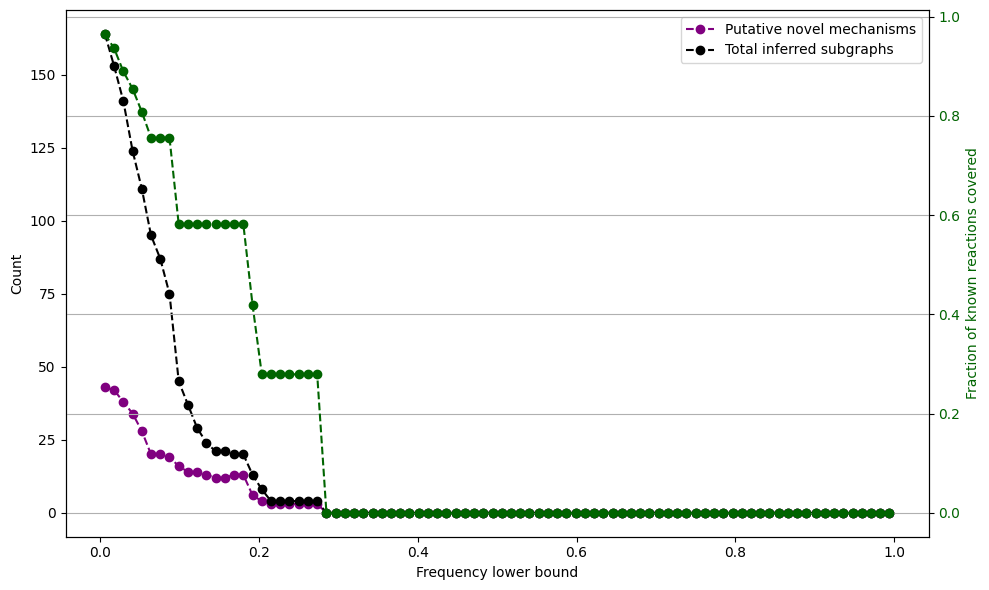

In [5]:
ax2_color = 'darkgreen'
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(ss["freq_lb"], ss["n_novel_subgraphs"], color='purple', ls='--', marker='o', label="Putative novel mechanisms")
ax1.plot(ss["freq_lb"], ss["n_total_inferred"], color='black', ls='--', marker='o', label="Total inferred subgraphs")
ax1.set_xlabel("Frequency lower bound")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
ax2.plot(
    ss['freq_lb'], 
    ss['rxn_cov_frac'],
    'o--', 
    label='Known reaction coverage', 
    color=ax2_color
)
ax2.set_ylabel('Fraction of known reactions covered', color=ax2_color)
ax2.tick_params(axis='y', labelcolor=ax2_color)

fig.tight_layout()
ax1.legend()
plt.grid()
plt.show()

In [6]:
frac_mech_cov = mc.groupby(["freq_lb", "mech_id"]).agg(
    max_coverage=("coverage", "max")
).groupby("freq_lb").agg(
    frac_mech_covered=("max_coverage", lambda x: np.sum(x == 1) / len(x))
)
frac_mech_cov.reset_index(inplace=True)
frac_mech_cov

,freq_lb,frac_mech_covered
0,0.005814,0.896552
1,0.017442,0.758621
2,0.029070,0.724138
3,0.040698,0.551724
4,0.052326,0.551724
5,0.063953,0.551724
6,0.075581,0.551724
7,0.087209,0.551724
8,0.098837,0.344828
9,0.110465,0.344828


In [7]:
extra_atoms = mc[mc["coverage"] == 1].groupby("freq_lb").agg(
    mean_atom_ratio=("atom_ratio", "mean"),
    stddev_atom_ratio=("atom_ratio", "std")
)
extra_atoms.reset_index(inplace=True)
extra_atoms

,freq_lb,mean_atom_ratio,stddev_atom_ratio
0,0.005814,3.443762,3.168987
1,0.017442,3.176331,3.239038
2,0.029070,2.976757,3.290977
3,0.040698,2.658036,2.810488
4,0.052326,2.590463,2.838801
5,0.063953,2.318598,1.921139
6,0.075581,2.058499,0.944516
7,0.087209,2.003064,0.847679
8,0.098837,1.911376,0.742023
9,0.110465,1.824653,0.638649


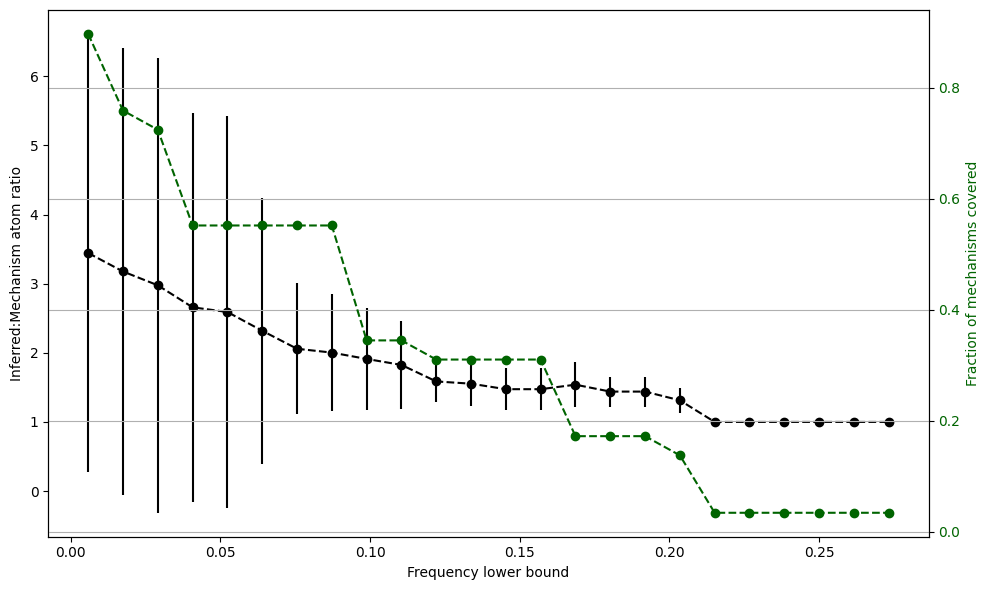

In [8]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot max_coverage with error bars
ax1.errorbar(
    x=extra_atoms['freq_lb'],
    y=extra_atoms['mean_atom_ratio'],
    yerr=extra_atoms['stddev_atom_ratio'],
    fmt='o--', 
    label='Inferred:Mechanism atom ratio', 
    color='black'
)
ax1.set_xlabel('Frequency lower bound')
ax1.set_ylabel('Inferred:Mechanism atom ratio', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for mean_extra_atoms
ax2 = ax1.twinx()
ax2.plot(
    frac_mech_cov['freq_lb'], 
    frac_mech_cov['frac_mech_covered'],
    'o--', 
    label='Fraction of mechanisms covered', 
    color='darkgreen'
)
ax2.set_ylabel('Fraction of mechanisms covered', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

# Adding grid and title
fig.tight_layout()
plt.grid(True)
plt.show()

In [9]:
fn = "mapped_sprhea_240310_v3_mapped_no_subunits_x_min_rules.parquet"
mapped = pd.read_parquet(Path(filepaths.raw_data) / fn)
mapped.head()

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id
0,0,NC(CCC=O)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O...,[NH2:7][CH:6]([CH2:5][CH2:3][CH:1]=[O:4])[C:8]...,[#6:1].[#6:2]1:[#6:3]:[#6:4]:[#6:5]:[#7+:6]:[#...,"4;3,4,5,6,7,47;2>>0,1;0,1,2,3,4,5",819
1,1,CC(O)C(O)C(O)C(O)C(=O)O>>CC(O)C(O)CC(=O)C(=O)O.O,[CH3:7][CH:5]([OH:8])[CH:4]([OH:6])[CH:1]([OH:...,([#6:1]-[#8:2].[#6:3]-[#8:4])>>([#6:1].[#6:3]=...,"5,6,7,8>>0,1,2;0",402
2,10,CCCCCCCCCCCC(=O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...,[CH3:14][CH2:13][CH2:12][CH2:11][CH2:10][CH2:9...,[#6:1]-[#8:2].[#8:3]-[#15:4]>>[#6:1]-[#8:3].[#...,"11,13;2,1>>0,1;0,1",994
3,100,*C(=O)OCC(COP(=O)(O)OC1C(O)C(OP(=O)(O)O)C(O)C(...,[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"15,16;0>>0,1;0",517
4,1000,CCC=O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)...,[CH3:5][CH2:3][CH:1]=[O:4].[NH2:13][C:12](=[O:...,[#6:1].[#6:2]1:[#6:3]:[#6:4]:[#6:5]:[#7+:6]:[#...,"2;3,4,5,6,7,47;0>>0,1;0,1,2,3,4,5",819


In [10]:
rule2rxn = defaultdict(set)
for _, row in mapped.iterrows():
    rule2rxn[row["rule_id"]].add(row["rxn_id"])

rule_cts = {rule_id: len(rxn_ids) for rule_id, rxn_ids in rule2rxn.items()}

Arithmetic mean: 22.02066772655008
Geometric mean: 3.7157720513429626
Harmonic mean: 2.082281855259684


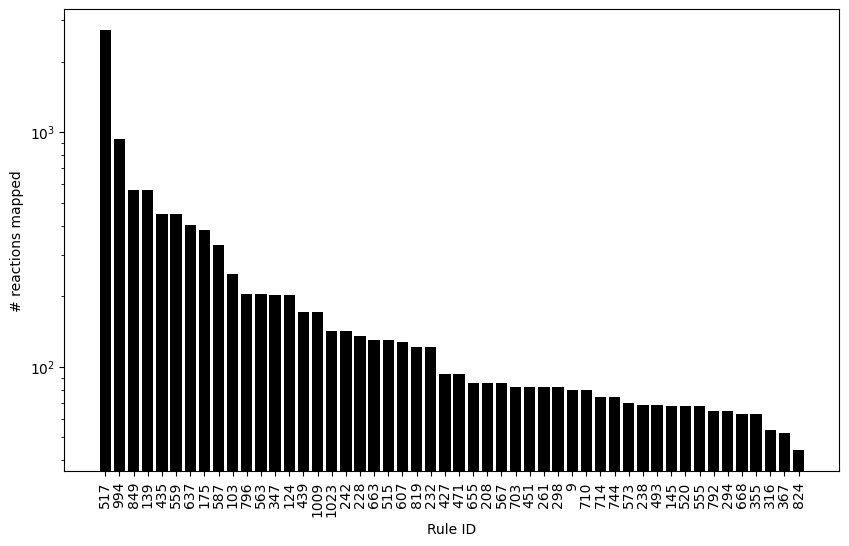

In [11]:
ds = 50
rule_ids, cts = zip(*sorted(rule_cts.items(), key=lambda item: item[1], reverse=True))
cts = np.array(cts)
print(f"Arithmetic mean: {cts.mean()}")
print(f"Geometric mean: {gmean(cts)}")
print(f"Harmonic mean: {hmean(cts)}")

x = np.arange(len(rule_ids[:ds]))
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, cts[:ds], color='black')
ax.set_xticks(x)
ax.set_xticklabels(rule_ids[:ds], rotation=90, ha='center')
ax.set_xlabel('Rule ID')
ax.set_ylabel('# reactions mapped')
ax.set_yscale('log')
plt.show()

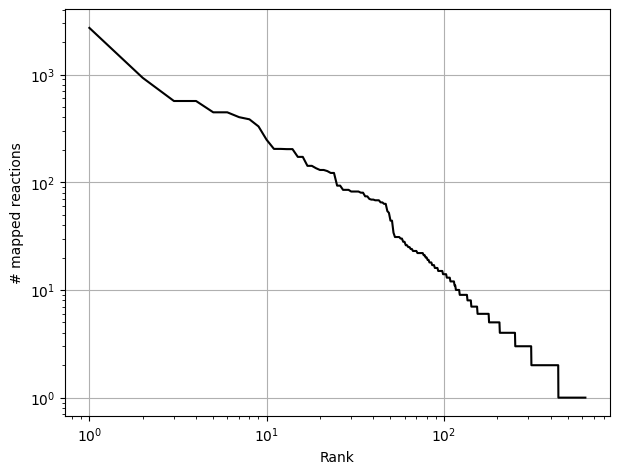

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(cts) + 1), cts, color='black')
ax.set_xlabel("Rank")
ax.set_ylabel("# mapped reactions")
ax.grid()
plt.tight_layout()
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [13]:
rule_cts[454]

5